<a href="https://colab.research.google.com/github/dolmani38/non-linear-regression/blob/master/Regession_test_0809.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install lime

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lime import lime_tabular, lime_text
from keras.utils import to_categorical
import datetime
import random

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_500_acc(y_true, y_pred):
    delta = 500
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_1000_acc(y_true, y_pred):
    delta = 1000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_10000_acc(y_true, y_pred):
    delta = 10000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_1perc_acc(y_true, y_pred):
    delta = 0.05
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))

def soft_5perc_acc(y_true, y_pred):
    delta = 0.05
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))

def soft_10perc_acc(y_true, y_pred):
    delta = 0.10
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))

def structure(df):
    """
    DataFrame의 column 등 전반적인 구조를 표출 한다.
    :param df:
    :return:
    """
    df1 = df.describe(include='all').T
    df1['type'] = df.dtypes
    df1['null count'] = df.isnull().sum()
    if 'freq' in df1.columns:
        df2 = df1[
            ['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top',
             'freq']]
    else:
        df2 = df1[['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

    return df2

class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values
            
class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else str(log).strip())),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - %s" % (self.epochs, str(logs)))

periodic_logger_10 = PeriodicLogger(10) 
periodic_logger_50 = PeriodicLogger(50)
periodic_logger_250 = PeriodicLogger(250)
periodic_logger_1000 = PeriodicLogger(1000)

     |████████████████████████████████| 276kB 11.2MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=699658ebd3d31b6342ee8d7da6147374586860013f3f24b97ac2312c75902fc2
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


## 성립 실험을 위한 시뮬레이션 데이터 생성

In [2]:
def nafyc_func(row):
    code,real_yy,rate = row['CODE'],row['REAL_YY'],row['COM_RATE']
    return real_yy * rate

In [3]:
def create_samples(n_samples):
    rate_table = {}
    samples = []
    for i in range(1000,1520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,500))
      for j in range(count):
        real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) * 10
        if code not in rate_table:
          rate = np.random.choice(range(1,100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]
        samples.append([code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CODE','REAL_YY','COM_RATE'])

In [4]:
dataset = create_samples(n_samples=1000)
dataset['NAFYC'] = dataset.apply(nafyc_func, axis=1)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,3155200,0.48,1514496.0
1,1000,64600,0.48,31008.0
2,1000,101000,0.48,48480.0
3,1000,927950,0.48,445416.0
4,1000,1814750,0.48,871080.0
...,...,...,...,...
132644,1519,1892440,0.55,1040842.0
132645,1519,2044240,0.55,1124332.0
132646,1519,31350,0.55,17242.5
132647,1519,2889480,0.55,1589214.0


## 성립 데이터 EDA

In [5]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max
CODE,int64,132649.0,0,1.254882e+03,1.525909e+02,1000.00,1120.00,1250.00,1389.00,1519.00
REAL_YY,int64,132649.0,0,2.495518e+06,2.200579e+06,40.00,678000.00,1864380.00,3806400.00,9930120.00
COM_RATE,float64,132649.0,0,5.176388e-01,2.881793e-01,0.01,0.28,0.52,0.77,0.99
NAFYC,float64,132649.0,0,1.292125e+06,1.489748e+06,18.40,213784.20,730512.00,1842926.40,9373298.20


In [6]:
dataset = dataset.astype({"CODE": object})

In [7]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CODE,object,132649.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520.0,1134.0,497.0
REAL_YY,int64,132649.0,0,2.495518e+06,2.200579e+06,40.00,678000.00,1864380.00,3806400.00,9930120.00,NaN,NaN,NaN
COM_RATE,float64,132649.0,0,5.176388e-01,2.881793e-01,0.01,0.28,0.52,0.77,0.99,NaN,NaN,NaN
NAFYC,float64,132649.0,0,1.292125e+06,1.489748e+06,18.40,213784.20,730512.00,1842926.40,9373298.20,NaN,NaN,NaN


In [8]:
dataset[dataset['CODE'] == 1386]

,CODE,REAL_YY,COM_RATE,NAFYC
98867,1386,4170770,0.8,3336616.0
98868,1386,1309800,0.8,1047840.0
98869,1386,6152000,0.8,4921600.0
98870,1386,2029480,0.8,1623584.0
98871,1386,856080,0.8,684864.0
...,...,...,...,...
99283,1386,1961760,0.8,1569408.0
99284,1386,1183400,0.8,946720.0
99285,1386,2064400,0.8,1651520.0
99286,1386,1162130,0.8,929704.0


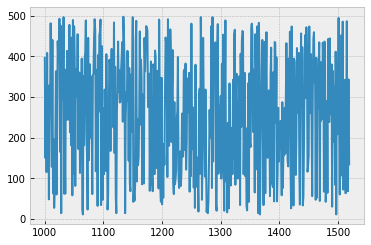

In [9]:
plt.plot(dataset.groupby('CODE')['CODE'].count())

## 성립데이터 전처리

In [10]:
# zscore norm

ds = dataset[['REAL_YY','COM_RATE']]

_mean = ds.mean(axis=0)
_std = ds.std(axis=0)

ds = ds - _mean
ds /= _std

dataset.update(ds)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,0.299777,-0.130609,1514496.0
1,1000,-1.104672,-0.130609,31008.0
2,1000,-1.088131,-0.130609,48480.0
3,1000,-0.712343,-0.130609,445416.0
4,1000,-0.309358,-0.130609,871080.0
...,...,...,...,...
132644,1519,-0.274054,0.112295,1040842.0
132645,1519,-0.205072,0.112295,1124332.0
132646,1519,-1.119782,0.112295,17242.5
132647,1519,0.179027,0.112295,1589214.0


In [11]:
code_mapping = EmbeddingMapping(dataset['CODE'])
dataset = dataset.assign(code_mapping=dataset['CODE'].apply(code_mapping.get_mapping))
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
0,1000,0.299777,-0.130609,1514496.0,1
1,1000,-1.104672,-0.130609,31008.0,1
2,1000,-1.088131,-0.130609,48480.0,1
3,1000,-0.712343,-0.130609,445416.0,1
4,1000,-0.309358,-0.130609,871080.0,1
...,...,...,...,...,...
132644,1519,-0.274054,0.112295,1040842.0,520
132645,1519,-0.205072,0.112295,1124332.0,520
132646,1519,-1.119782,0.112295,17242.5,520
132647,1519,0.179027,0.112295,1589214.0,520


In [12]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['REAL_YY','code_mapping']],
    dataset['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['REAL_YY']]
X_train_categorical = X_train_org[['code_mapping']]

X_val_continuous  = X_val_org[['REAL_YY']]
X_val_categorical = X_val_org[['code_mapping']]


## 성립 데이터 학습 네트워크 구성 및 학습

In [14]:
# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10000_acc,r2])
model.summary()

epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Tensor("concatenate_1/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 64)        33344       input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 64)           0           embedding_1[0][0]                
_____________________

## 학습 결과 확인

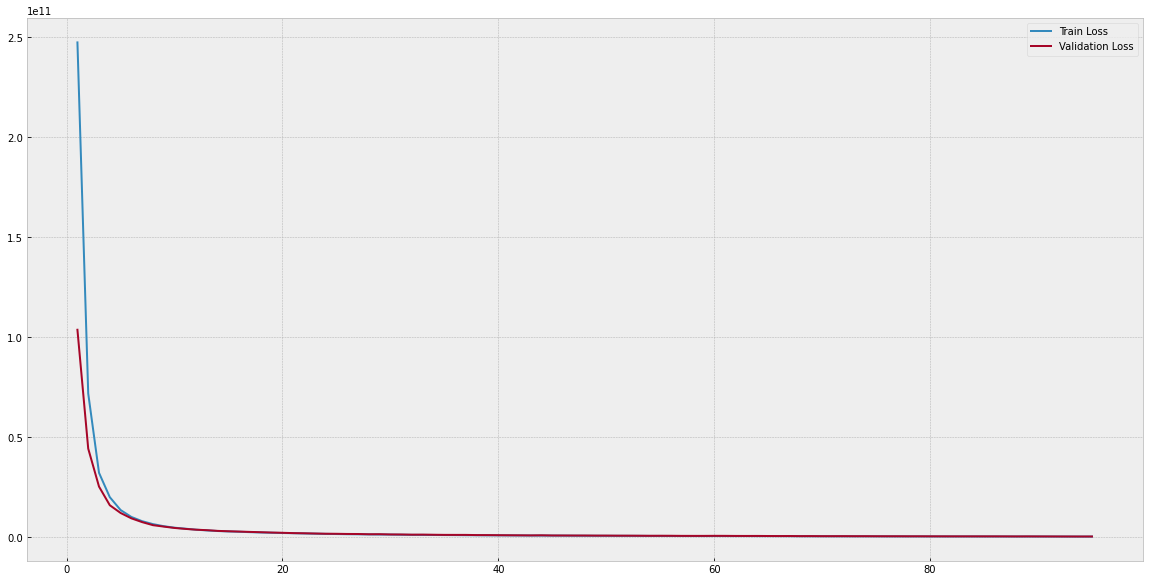

In [15]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][5:]
_val_loss = history.history['val_loss'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 1319640
The mean is very close to 0 (-1249.88) with std. 20520.67.


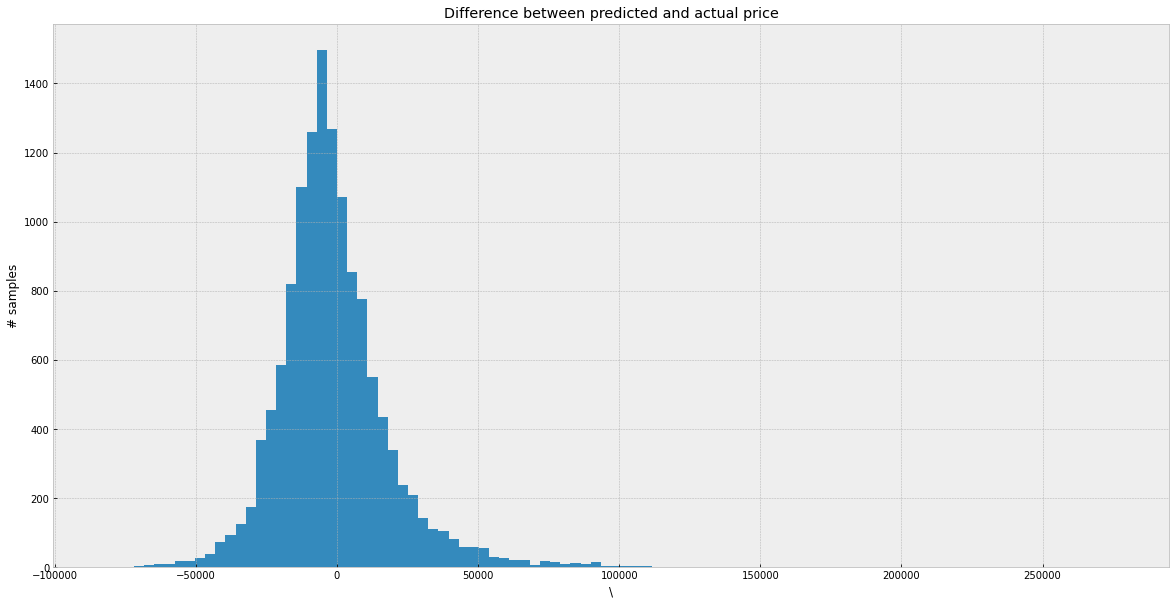

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
96479,8056334.000,276808.400,276808.400,3.558166,3.558166,1376,3.074565,1.118613,7779525.6,377
96446,7700910.500,246448.100,246448.100,3.306048,3.306048,1376,2.898711,1.118613,7454462.4,377
87753,6835063.500,245183.500,245183.500,3.720606,3.720606,1345,2.609237,0.979811,6589880.0,346
96466,7630322.500,240926.500,240926.500,3.260436,3.260436,1376,2.863511,1.118613,7389396.0,377
24845,6039537.000,221128.800,221128.800,3.800503,3.800503,1090,2.872086,0.494002,5818408.2,91
132070,8133246.500,182873.300,182873.300,2.300185,2.300185,1516,3.018679,1.222715,7950373.2,517
114503,8882460.000,164317.200,164317.200,1.884773,1.884773,1451,3.080599,1.465620,8718142.8,452
17677,2045485.875,156337.075,156337.075,8.275530,8.275530,1064,2.768145,-1.032825,1889148.8,65
48129,7707867.000,145867.000,145867.000,1.928947,1.928947,1174,3.161433,0.979811,7562000.0,175
116130,5451024.500,137573.000,137573.000,2.589146,2.589146,1456,2.958463,0.251098,5313451.5,457


In [16]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['code_mapping']])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

In [17]:
dataset[dataset['code_mapping']==3]

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
546,1002,-0.038498,-0.269411,1060752.0,3
547,1002,-0.833016,-0.269411,291456.0,3
548,1002,-0.385225,-0.269411,725032.0,3
549,1002,0.044335,-0.269411,1140955.2,3
550,1002,0.388163,-0.269411,1473868.0,3
...,...,...,...,...,...
840,1002,1.780451,-0.269411,2821957.6,3
841,1002,1.640806,-0.269411,2686745.6,3
842,1002,0.624782,-0.269411,1702976.0,3
843,1002,0.068565,-0.269411,1164416.0,3


## 성립 데이터에 대한 파생변수 추가 실험
# NAFYC 산출 관계식에 의한 파생변수 추가 

In [19]:
dataset['ft1'] = dataset['REAL_YY']* dataset['COM_RATE']

In [20]:
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping,ft1
0,1000,0.299777,-0.130609,1514496.0,1,-0.039154
1,1000,-1.104672,-0.130609,31008.0,1,0.144280
2,1000,-1.088131,-0.130609,48480.0,1,0.142120
3,1000,-0.712343,-0.130609,445416.0,1,0.093038
4,1000,-0.309358,-0.130609,871080.0,1,0.040405
...,...,...,...,...,...,...
132644,1519,-0.274054,0.112295,1040842.0,520,-0.030775
132645,1519,-0.205072,0.112295,1124332.0,520,-0.023029
132646,1519,-1.119782,0.112295,17242.5,520,-0.125746
132647,1519,0.179027,0.112295,1589214.0,520,0.020104


In [21]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['REAL_YY','ft1','code_mapping']],
    dataset['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['REAL_YY','ft1']]
X_train_categorical = X_train_org[['code_mapping']]

X_val_continuous  = X_val_org[['REAL_YY','ft1']]
X_val_categorical = X_val_org[['code_mapping']]


## 네크워크 구성 (기존과 동일) 및 학습

In [22]:
# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10000_acc,r2])
model.summary()

epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Tensor("concatenate_2/concat:0", shape=(None, 66), dtype=float32)
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 64)        33344       input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 64)           0           embedding_2[0][0]                
_____________________

## 학습 결과 확인

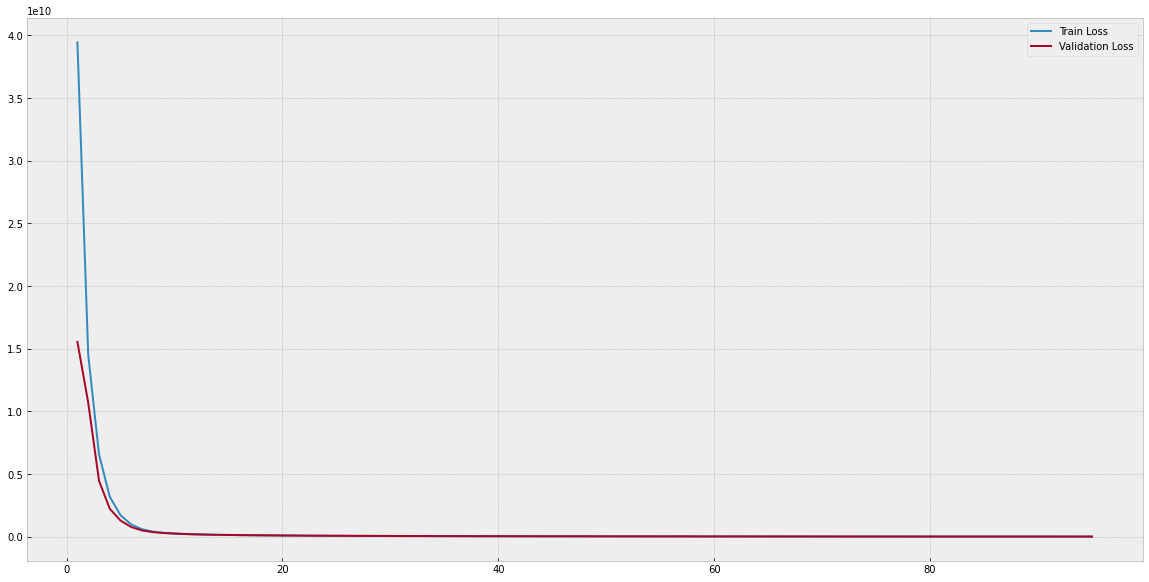

In [23]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][5:]
_val_loss = history.history['val_loss'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

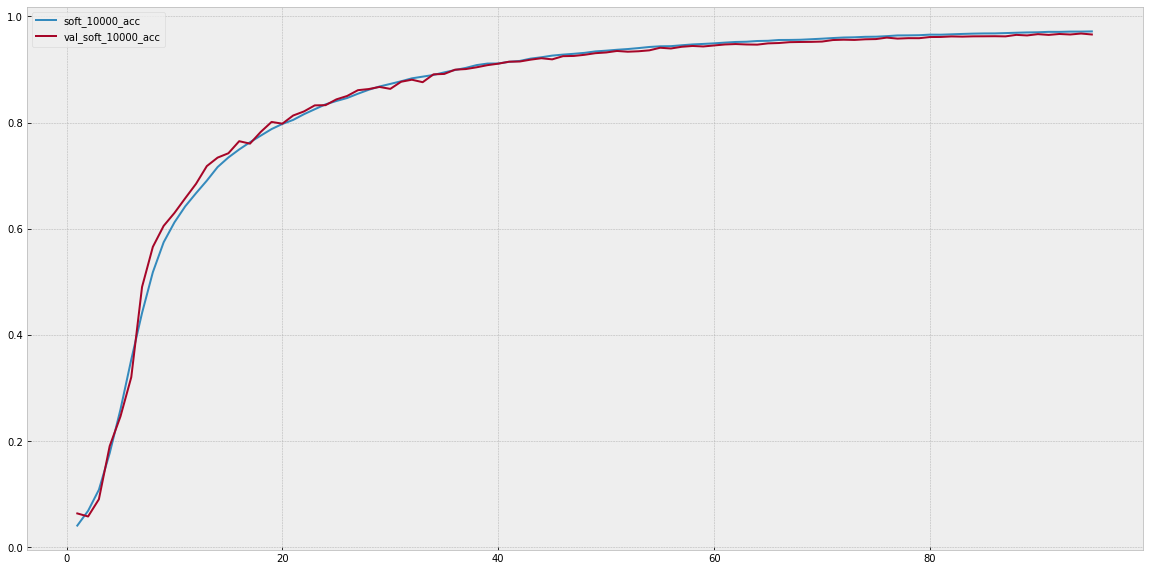

In [24]:
plt.figure(figsize=(20,10))
_loss = history.history['soft_10000_acc'][5:]
_val_loss = history.history['val_soft_10000_acc'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='soft_10000_acc')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='val_soft_10000_acc')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 1319640
The mean is very close to 0 (496.54) with std. 4077.21.


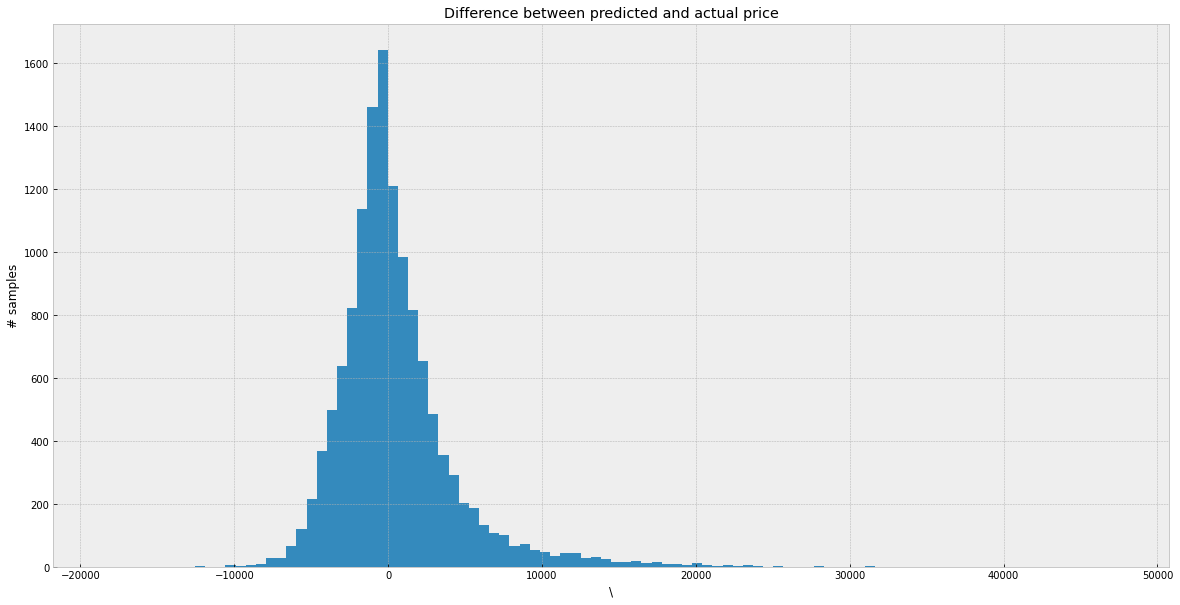

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping,ft1
71924,9.250892e+05,47448.850000,47448.850000,5.406411,5.406411,1275,3.297333,-1.483933,877640.4,276,-4.893023
9220,3.676236e+06,41987.550000,41987.550000,1.155330,1.155330,1035,2.894012,-0.373513,3634248.2,36,-1.080952
63286,1.008379e+06,37224.875000,37224.875000,3.833056,3.833056,1237,3.279147,-1.449233,971154.0,238,-4.752247
102853,4.369442e+04,37214.417969,37214.417969,574.296574,574.296574,1403,-1.130756,1.326817,6480.0,404,-1.500306
95352,4.070174e+06,35576.700000,35576.700000,0.881791,0.881791,1372,3.337741,-0.373513,4034596.8,373,-1.246691
47222,2.644445e+06,33540.200000,33540.200000,1.284620,1.284620,1172,2.957223,-0.789921,2610904.8,173,-2.335972
47580,2.643388e+06,33457.100000,33457.100000,1.281915,1.281915,1172,2.955696,-0.789921,2609930.4,173,-2.334766
63178,9.578297e+05,31429.687500,31429.687500,3.392669,3.392669,1237,3.075773,-1.449233,926400.0,238,-4.457511
42252,1.513583e+06,31330.575000,31330.575000,2.113713,2.113713,1153,3.075810,-1.241029,1482252.8,154,-3.817169
101480,5.268154e+04,31019.742969,31019.742969,143.200209,143.200209,1396,-1.121567,0.945110,21661.8,397,-1.060005


In [25]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['code_mapping']])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

In [29]:
dataset = dataset.astype({"COM_RATE": object})
crate_mapping = EmbeddingMapping(dataset['COM_RATE'])
dataset = dataset.assign(crate_mapping=dataset['COM_RATE'].apply(crate_mapping .get_mapping))
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CODE,object,132649.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520.0,1134.000000,497.0
REAL_YY,float64,132649.0,0,-5.074088e-18,1.000000e+00,-1.134010,-0.825927,-0.286805,5.956988e-01,3.378476e+00,NaN,NaN,NaN
COM_RATE,object,132649.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,1.604422,4071.0
NAFYC,float64,132649.0,0,1.292125e+06,1.489748e+06,18.400000,213784.200000,730512.000000,1.842926e+06,9.373298e+06,NaN,NaN,NaN
code_mapping,int64,132649.0,0,2.558825e+02,1.525909e+02,1.000000,121.000000,251.000000,3.900000e+02,5.200000e+02,NaN,NaN,NaN
ft1,float64,132649.0,0,5.484999e-04,1.003420e+00,-5.759565,-0.492364,0.000340,4.835544e-01,5.153996e+00,NaN,NaN,NaN
crate_mapping,int64,132649.0,0,4.459022e+01,2.760446e+01,1.000000,21.000000,42.000000,6.800000e+01,9.900000e+01,NaN,NaN,NaN


In [30]:
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping,ft1,crate_mapping
0,1000,0.299777,-0.130609,1514496.0,1,-0.039154,1
1,1000,-1.104672,-0.130609,31008.0,1,0.144280,1
2,1000,-1.088131,-0.130609,48480.0,1,0.142120,1
3,1000,-0.712343,-0.130609,445416.0,1,0.093038,1
4,1000,-0.309358,-0.130609,871080.0,1,0.040405,1
...,...,...,...,...,...,...,...
132644,1519,-0.274054,0.112295,1040842.0,520,-0.030775,93
132645,1519,-0.205072,0.112295,1124332.0,520,-0.023029,93
132646,1519,-1.119782,0.112295,17242.5,520,-0.125746,93
132647,1519,0.179027,0.112295,1589214.0,520,0.020104,93


In [31]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['REAL_YY','ft1','code_mapping','crate_mapping']],
    dataset['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['REAL_YY','ft1']]
X_train_categorical = X_train_org[['code_mapping','crate_mapping']]

X_val_continuous  = X_val_org[['REAL_YY','ft1']]
X_val_categorical = X_val_org[['code_mapping','crate_mapping']]

In [34]:
# Define the embedding input
code_input = Input(shape=(2,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim*2,))(code_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10000_acc,r2])
model.summary()


Tensor("concatenate_4/concat:0", shape=(None, 130), dtype=float32)
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 2, 64)        33344       input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 128)          0           embedding_4[0][0]                
____________________

In [35]:

epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical], Y_val))

Epoch: 10 - {'loss': 1633440000.0, 'soft_5perc_acc': 0.6536322236061096, 'soft_10000_acc': 0.23454706370830536, 'r2': 0.9992654323577881, 'val_loss': 1095971968.0, 'val_soft_5perc_acc': 0.7082048654556274, 'val_soft_10000_acc': 0.3381848931312561, 'val_r2': 0.9995036721229553}
Epoch: 20 - {'loss': 130031344.0, 'soft_5perc_acc': 0.8312905430793762, 'soft_10000_acc': 0.7559690475463867, 'r2': 0.999941349029541, 'val_loss': 127446480.0, 'val_soft_5perc_acc': 0.8361172676086426, 'val_soft_10000_acc': 0.7623701095581055, 'val_r2': 0.9999426603317261}
Epoch: 30 - {'loss': 60999136.0, 'soft_5perc_acc': 0.8609225153923035, 'soft_10000_acc': 0.874286949634552, 'r2': 0.9999725222587585, 'val_loss': 61482820.0, 'val_soft_5perc_acc': 0.865118682384491, 'val_soft_10000_acc': 0.8820884227752686, 'val_r2': 0.9999722242355347}
Epoch: 40 - {'loss': 49555012.0, 'soft_5perc_acc': 0.8554628491401672, 'soft_10000_acc': 0.8804380297660828, 'r2': 0.9999775886535645, 'val_loss': 59345860.0, 'val_soft_5perc_ac

In [45]:
# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim*1,))(code_embedings)

rate_input = Input(shape=(1,), dtype='int32') 
output_dim=32   #X_train_categorical['code_mapping'].max()*1
rate_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['crate_mapping'].max()+1)(rate_input)
rate_embedings = keras.layers.Reshape((output_dim*1,))(rate_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings,rate_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input,rate_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10000_acc,r2])
model.summary()

Tensor("concatenate_9/concat:0", shape=(None, 98), dtype=float32)
Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 64)        33344       input_23[0][0]                   
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1, 32)        3200        input_24[0][0]                   
____________________

In [46]:
epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping'], X_train_categorical['crate_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping'], X_val_categorical['crate_mapping']], Y_val))

Epoch: 10 - {'loss': 6606609920.0, 'soft_5perc_acc': 0.5609285235404968, 'soft_10000_acc': 0.16034220159053802, 'r2': 0.9970263838768005, 'val_loss': 4092379136.0, 'val_soft_5perc_acc': 0.6087813973426819, 'val_soft_10000_acc': 0.14210376143455505, 'val_r2': 0.9981415271759033}
Epoch: 20 - {'loss': 105215824.0, 'soft_5perc_acc': 0.8206830620765686, 'soft_10000_acc': 0.8036206364631653, 'r2': 0.9999526143074036, 'val_loss': 105099608.0, 'val_soft_5perc_acc': 0.831895112991333, 'val_soft_10000_acc': 0.814913272857666, 'val_r2': 0.9999524354934692}
Epoch: 30 - {'loss': 73227368.0, 'soft_5perc_acc': 0.8313736915588379, 'soft_10000_acc': 0.8415243625640869, 'r2': 0.9999668598175049, 'val_loss': 134006808.0, 'val_soft_5perc_acc': 0.7986029386520386, 'val_soft_10000_acc': 0.7898558378219604, 'val_r2': 0.99993896484375}
Epoch: 40 - {'loss': 41809484.0, 'soft_5perc_acc': 0.8567958474159241, 'soft_10000_acc': 0.8828520178794861, 'r2': 0.999981164932251, 'val_loss': 38533568.0, 'val_soft_5perc_ac

## lime에 의한 XAI 싷험

In [251]:
train_ds = pd.concat([X_train_continuous,X_train_categorical], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical], axis=1)

# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=Y_train,
    feature_names=train_ds.columns,
    class_names= ['NAFYC'],
    mode="regression"
)

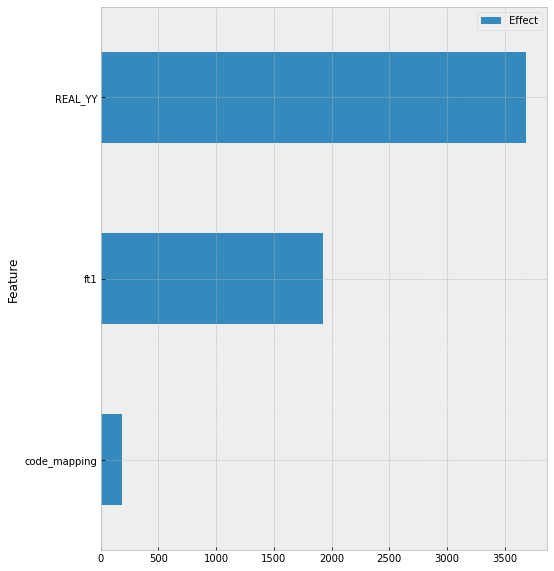

,Feature,Effect
0,code_mapping,186.249600
1,ft1,1929.124541
2,REAL_YY,3681.139030


In [252]:
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])

import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'])
effect_result_table['Effect'] = effect_result_table['Effect']/10000
effect_result_table.plot(x='Feature',y='Effect', figsize=(8, 10),kind='barh')
plt.show()
effect_result_table

## 실효/해약 등 Event 시뮬레이션 데이터 생성

In [7]:
contract_change_rules = {
    '성립': 0,
    '실효': -0.4,
    '해약': -0.8,
    '철회': -0.5,
    '변경': -0.1
}

def create_samples2():
    rate_table = {}
    samples = []
    start_date = datetime.date(2015, 1, 1)
    end_date = datetime.date(2020, 8, 8)

    for i in range(1000,1520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,250))
      for j in range(count):
        cntr_no = str(random.choice(range(100000,500000))) + ':' + str(random.choice(range(100000,500000)))
        real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) # * 100
        if code not in rate_table:
          rate = np.random.choice(range(1,100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]

        div = '성립'
        minus_rate = 0

        # 계약일 생성
        time_between_dates = end_date - start_date
        days_between_dates = time_between_dates.days
        random_number_of_days = random.randrange(days_between_dates)
        contract_date = start_date + datetime.timedelta(days=random_number_of_days)
        event_date = contract_date
        # 계약 총개월수 생성 
        contract_months = np.random.choice(range(12,12*30))
        event_num = 0
        samples.append([cntr_no,div,event_num,minus_rate,contract_date,contract_months,event_date,code,real_yy,rate])
        event_proba = np.random.choice(range(0,100))
        if event_proba < 10: # 10%의 확률로...Event 발생
          for changes in range(19):
            event_num += 1
            div = random.choice(['실효','해약','철회','변경'])
            # Event 발생일 생성 
            time_between_dates = end_date - event_date
            days_between_dates = time_between_dates.days
            random_number_of_days = random.randrange(days_between_dates)
            event_date = event_date + datetime.timedelta(days=random_number_of_days)
            if div=='변경':
              contract_date = event_date
              code = np.random.choice(range(1000,1520))
              real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) # * 100
              contract_months = np.random.choice(range(12,12*30))       
              if code not in rate_table:
                rate = np.random.choice(range(1,100)) / 100
                rate_table[code] = rate
              else:
                rate = rate_table[code]
            elif div=='해약':
              samples.append([cntr_no,div,event_num,contract_change_rules[div],contract_date,contract_months,event_date,code,real_yy,rate])
              break

            samples.append([cntr_no,div,event_num,contract_change_rules[div],contract_date,contract_months,event_date,code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CONTRACT_ID','DIV','EVENT_NUM','MINUS_RATE','CONTRACT_DATE','CONTRACT_MONTHS','EVENT_DATE','CODE','REAL_YY','COM_RATE'])

In [8]:
dataset2 = create_samples2()

In [9]:
dataset2.head(20)

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE
0,196008:416487,성립,0,0.0,2019-02-09,206,2019-02-09,1000,10001,0.84
1,361529:195752,성립,0,0.0,2016-01-01,85,2016-01-01,1000,72092,0.84
2,128561:274426,성립,0,0.0,2017-10-16,334,2017-10-16,1000,105336,0.84
3,475898:318151,성립,0,0.0,2019-04-12,52,2019-04-12,1000,488125,0.84
4,145696:284645,성립,0,0.0,2020-03-17,308,2020-03-17,1000,177608,0.84
5,149489:323177,성립,0,0.0,2016-08-14,129,2016-08-14,1000,9223,0.84
6,144657:248142,성립,0,0.0,2019-08-08,23,2019-08-08,1000,265954,0.84
7,276930:101298,성립,0,0.0,2019-09-19,140,2019-09-19,1000,279752,0.84
8,488544:229559,성립,0,0.0,2015-09-03,141,2015-09-03,1000,88440,0.84
9,194579:126416,성립,0,0.0,2016-02-02,228,2016-02-02,1000,2296,0.84


In [10]:
structure(dataset2)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CONTRACT_ID,object,93082,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66349,215491:181512,20
DIV,object,93082,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,성립,66349
EVENT_NUM,int64,93082,0,1.11105,2.43265,0,0,0,1,19,NaN,NaN,NaN
MINUS_RATE,float64,93082,0,-0.129299,0.243727,-0.8,-0.1,0,0,0,NaN,NaN,NaN
CONTRACT_DATE,object,93082,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046,2020-08-07,2839
CONTRACT_MONTHS,int64,93082,0,185.333,100.219,12,99,185,272,359,NaN,NaN,NaN
EVENT_DATE,object,93082,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046,2020-08-07,4656
CODE,int64,93082,0,1257.79,148.207,1000,1129,1259,1383,1519,NaN,NaN,NaN
REAL_YY,int64,93082,0,249394,220358,7,67600,185368,380072,989024,NaN,NaN,NaN
COM_RATE,float64,93082,0,0.526836,0.28087,0.01,0.29,0.56,0.77,0.99,NaN,NaN,NaN


In [11]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [12]:
back_nafyc = {}

def nafyc_func2(row):
  CONTRACT_ID = row['CONTRACT_ID']
  DIV = row['DIV']
  MINUS_RATE = row['MINUS_RATE']
  CONTRACT_DATE = row['CONTRACT_DATE']
  CONTRACT_MONTHS = row['CONTRACT_MONTHS']
  EVENT_DATE = row['EVENT_DATE']
  CODE = row['CODE']
  REAL_YY = row['REAL_YY']
  COM_RATE = row['COM_RATE']
  if DIV=='성립':
    nafyc = REAL_YY * COM_RATE
    old_nafyc = 0
    back_nafyc[CONTRACT_ID] = nafyc
  else:
    nafyc = back_nafyc[CONTRACT_ID]
    old_nafyc = nafyc
    if DIV=='변경':
      nafyc = REAL_YY * COM_RATE
    else:
      # event가 발생하면 nafyc = nafyc + nafyc * (남은기간/전체기간 * 마이너스비율) --> 이건 임의도 관계식 넣은것임... 실 처리과정은 아님
      nafyc = nafyc + nafyc * MINUS_RATE * ((diff_month(EVENT_DATE,CONTRACT_DATE))/CONTRACT_MONTHS)
    back_nafyc[CONTRACT_ID] = nafyc
    #if nafyc == old_nafyc:
    #  old_nafyc = 0
  return nafyc - old_nafyc

In [13]:
dataset2['NAFYC'] = dataset2.apply(nafyc_func2, axis=1)

In [14]:
dataset2.head(20)

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC
0,196008:416487,성립,0,0.0,2019-02-09,206,2019-02-09,1000,10001,0.84,8400.840000
1,361529:195752,성립,0,0.0,2016-01-01,85,2016-01-01,1000,72092,0.84,60557.280000
2,128561:274426,성립,0,0.0,2017-10-16,334,2017-10-16,1000,105336,0.84,88482.240000
3,475898:318151,성립,0,0.0,2019-04-12,52,2019-04-12,1000,488125,0.84,410025.000000
4,145696:284645,성립,0,0.0,2020-03-17,308,2020-03-17,1000,177608,0.84,149190.720000
5,149489:323177,성립,0,0.0,2016-08-14,129,2016-08-14,1000,9223,0.84,7747.320000
6,144657:248142,성립,0,0.0,2019-08-08,23,2019-08-08,1000,265954,0.84,223401.360000
7,276930:101298,성립,0,0.0,2019-09-19,140,2019-09-19,1000,279752,0.84,234991.680000
8,488544:229559,성립,0,0.0,2015-09-03,141,2015-09-03,1000,88440,0.84,74289.600000
9,194579:126416,성립,0,0.0,2016-02-02,228,2016-02-02,1000,2296,0.84,1928.640000


## EDA 과정

In [15]:
dataset2.groupby('CONTRACT_ID').count().max()

DIV                20
EVENT_NUM          20
MINUS_RATE         20
CONTRACT_DATE      20
CONTRACT_MONTHS    20
EVENT_DATE         20
CODE               20
REAL_YY            20
COM_RATE           20
NAFYC              20
dtype: int64

## 데이터 전처리...

In [16]:
dataset2 = dataset2.astype({"CODE": object})


In [17]:
structure(dataset2)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CONTRACT_ID,object,93082,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66349,215491:181512,20
DIV,object,93082,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,성립,66349
EVENT_NUM,int64,93082,0,1.11105,2.43265,0,0,0,1,19,NaN,NaN,NaN
MINUS_RATE,float64,93082,0,-0.129299,0.243727,-0.8,-0.1,0,0,0,NaN,NaN,NaN
CONTRACT_DATE,object,93082,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046,2020-08-07,2839
CONTRACT_MONTHS,int64,93082,0,185.333,100.219,12,99,185,272,359,NaN,NaN,NaN
EVENT_DATE,object,93082,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046,2020-08-07,4656
CODE,object,93082,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520,1317,479
REAL_YY,int64,93082,0,249394,220358,7,67600,185368,380072,989024,NaN,NaN,NaN
COM_RATE,float64,93082,0,0.526836,0.28087,0.01,0.29,0.56,0.77,0.99,NaN,NaN,NaN


## 파생변수의 추가

In [18]:
pre_nafycs = []
pre_nafyc = 0
for row in dataset2.iterrows():
  if row[1][2] == 0:
    pre_nafycs.append(0)
    pre_nafyc = 0
  else:
    pre_nafycs.append(pre_nafyc)
    
  pre_nafyc = pre_nafyc + row[1][10]
  
dataset2['PRE_NAFYC'] = pre_nafycs

In [19]:
def last_months(row):
  CONTRACT_DATE = row['CONTRACT_DATE']
  CONTRACT_MONTHS = row['CONTRACT_MONTHS']
  EVENT_DATE = row['EVENT_DATE']
  return diff_month(EVENT_DATE,CONTRACT_DATE)

dataset2['LAST_MONTHS'] = dataset2.apply(last_months, axis=1)

In [21]:
dataset2.head(20)

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,PRE_NAFYC,LAST_MONTHS
0,196008:416487,성립,0,0.0,2019-02-09,206,2019-02-09,1000,10001,0.84,8400.840000,0.00000,0
1,361529:195752,성립,0,0.0,2016-01-01,85,2016-01-01,1000,72092,0.84,60557.280000,0.00000,0
2,128561:274426,성립,0,0.0,2017-10-16,334,2017-10-16,1000,105336,0.84,88482.240000,0.00000,0
3,475898:318151,성립,0,0.0,2019-04-12,52,2019-04-12,1000,488125,0.84,410025.000000,0.00000,0
4,145696:284645,성립,0,0.0,2020-03-17,308,2020-03-17,1000,177608,0.84,149190.720000,0.00000,0
5,149489:323177,성립,0,0.0,2016-08-14,129,2016-08-14,1000,9223,0.84,7747.320000,0.00000,0
6,144657:248142,성립,0,0.0,2019-08-08,23,2019-08-08,1000,265954,0.84,223401.360000,0.00000,0
7,276930:101298,성립,0,0.0,2019-09-19,140,2019-09-19,1000,279752,0.84,234991.680000,0.00000,0
8,488544:229559,성립,0,0.0,2015-09-03,141,2015-09-03,1000,88440,0.84,74289.600000,0.00000,0
9,194579:126416,성립,0,0.0,2016-02-02,228,2016-02-02,1000,2296,0.84,1928.640000,0.00000,0


In [22]:
# zscore norm

ds = dataset2[['REAL_YY','PRE_NAFYC','CONTRACT_MONTHS','LAST_MONTHS']]

_mean = ds.mean(axis=0)
_std = ds.std(axis=0)

ds = ds - _mean
ds /= _std

dataset2.update(ds)
dataset2

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,PRE_NAFYC,LAST_MONTHS
0,196008:416487,성립,0,0.0,2019-02-09,0.206214,2019-02-09,1000,-1.086380,0.84,8400.840000,-0.375254,-0.311553
1,361529:195752,성립,0,0.0,2016-01-01,-1.001144,2016-01-01,1000,-0.804607,0.84,60557.280000,-0.375254,-0.311553
2,128561:274426,성립,0,0.0,2017-10-16,1.483419,2017-10-16,1000,-0.653744,0.84,88482.240000,-0.375254,-0.311553
3,475898:318151,성립,0,0.0,2019-04-12,-1.330423,2019-04-12,1000,1.083378,0.84,410025.000000,-0.375254,-0.311553
4,145696:284645,성립,0,0.0,2020-03-17,1.223987,2020-03-17,1000,-0.325769,0.84,149190.720000,-0.375254,-0.311553
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93077,219042:159116,성립,0,0.0,2020-01-04,-0.592039,2020-01-04,1351,-1.126266,0.91,1102.920000,-0.375254,-0.311553
93078,219042:159116,실효,1,-0.4,2020-01-04,-0.592039,2020-07-25,1351,-1.126266,0.91,-21.008000,-0.363731,0.325972
93079,219042:159116,해약,2,-0.8,2020-01-04,-0.592039,2020-07-28,1351,-1.126266,0.91,-41.215695,-0.363950,0.325972
93080,385281:439082,성립,0,0.0,2015-01-04,-1.639747,2015-01-04,1351,-0.225564,0.91,181716.990000,-0.375254,-0.311553


In [23]:
dataset2['ft1'] = dataset2['REAL_YY']* dataset2['COM_RATE']
dataset2['ft2'] = dataset2['LAST_MONTHS']/dataset2['CONTRACT_MONTHS']
dataset2['ft3'] = dataset2['MINUS_RATE']*dataset2['LAST_MONTHS']/dataset2['CONTRACT_MONTHS']
dataset2['ft4'] = dataset2['PRE_NAFYC']+dataset2['PRE_NAFYC']*dataset2['MINUS_RATE']*dataset2['LAST_MONTHS']/dataset2['CONTRACT_MONTHS']

In [24]:
dataset2 = dataset2.astype({"MINUS_RATE": object})
dataset2 = dataset2.astype({"COM_RATE": object})

In [25]:
dataset2

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,PRE_NAFYC,LAST_MONTHS,ft1,ft2,ft3,ft4
0,196008:416487,성립,0,0,2019-02-09,0.206214,2019-02-09,1000,-1.086380,0.84,8400.840000,-0.375254,-0.311553,-0.912560,-1.510823,-0.000000,-0.375254
1,361529:195752,성립,0,0,2016-01-01,-1.001144,2016-01-01,1000,-0.804607,0.84,60557.280000,-0.375254,-0.311553,-0.675870,0.311197,0.000000,-0.375254
2,128561:274426,성립,0,0,2017-10-16,1.483419,2017-10-16,1000,-0.653744,0.84,88482.240000,-0.375254,-0.311553,-0.549145,-0.210023,-0.000000,-0.375254
3,475898:318151,성립,0,0,2019-04-12,-1.330423,2019-04-12,1000,1.083378,0.84,410025.000000,-0.375254,-0.311553,0.910037,0.234176,0.000000,-0.375254
4,145696:284645,성립,0,0,2020-03-17,1.223987,2020-03-17,1000,-0.325769,0.84,149190.720000,-0.375254,-0.311553,-0.273646,-0.254539,-0.000000,-0.375254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93077,219042:159116,성립,0,0,2020-01-04,-0.592039,2020-01-04,1351,-1.126266,0.91,1102.920000,-0.375254,-0.311553,-1.024902,0.526236,0.000000,-0.375254
93078,219042:159116,실효,1,-0.4,2020-01-04,-0.592039,2020-07-25,1351,-1.126266,0.91,-21.008000,-0.363731,0.325972,-1.024902,-0.550592,0.220237,-0.443838
93079,219042:159116,해약,2,-0.8,2020-01-04,-0.592039,2020-07-28,1351,-1.126266,0.91,-41.215695,-0.363950,0.325972,-1.024902,-0.550592,0.440474,-0.524261
93080,385281:439082,성립,0,0,2015-01-04,-1.639747,2015-01-04,1351,-0.225564,0.91,181716.990000,-0.375254,-0.311553,-0.205263,0.190000,0.000000,-0.375254


In [26]:
# 상품코드의 categpry mapping
code_mapping = EmbeddingMapping(dataset2['CODE'])
dataset2 = dataset2.assign(code_mapping=dataset2['CODE'].apply(code_mapping.get_mapping))
# event구분의 category mapping
div_mapping = EmbeddingMapping(dataset2['DIV'])
dataset2 = dataset2.assign(div_mapping=dataset2['DIV'].apply(div_mapping.get_mapping))
# EVENT_NUM의 category mapping
eventint_mapping = EmbeddingMapping(dataset2['EVENT_NUM'])
dataset2 = dataset2.assign(eventint_mapping=dataset2['EVENT_NUM'].apply(eventint_mapping.get_mapping))
# COM_RATE의 category mapping
comrate_mapping = EmbeddingMapping(dataset2['COM_RATE'])
dataset2 = dataset2.assign(comrate_mapping=dataset2['COM_RATE'].apply(comrate_mapping.get_mapping))
# MINUS_RATE category mapping
minusrate_mapping = EmbeddingMapping(dataset2['MINUS_RATE'])
dataset2 = dataset2.assign(minusrate_mapping=dataset2['MINUS_RATE'].apply(minusrate_mapping.get_mapping))


dataset2

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,PRE_NAFYC,LAST_MONTHS,ft1,ft2,ft3,ft4,code_mapping,div_mapping,eventint_mapping,comrate_mapping,minusrate_mapping
0,196008:416487,성립,0,0,2019-02-09,0.206214,2019-02-09,1000,-1.086380,0.84,8400.840000,-0.375254,-0.311553,-0.912560,-1.510823,-0.000000,-0.375254,1,1,1,1,1
1,361529:195752,성립,0,0,2016-01-01,-1.001144,2016-01-01,1000,-0.804607,0.84,60557.280000,-0.375254,-0.311553,-0.675870,0.311197,0.000000,-0.375254,1,1,1,1,1
2,128561:274426,성립,0,0,2017-10-16,1.483419,2017-10-16,1000,-0.653744,0.84,88482.240000,-0.375254,-0.311553,-0.549145,-0.210023,-0.000000,-0.375254,1,1,1,1,1
3,475898:318151,성립,0,0,2019-04-12,-1.330423,2019-04-12,1000,1.083378,0.84,410025.000000,-0.375254,-0.311553,0.910037,0.234176,0.000000,-0.375254,1,1,1,1,1
4,145696:284645,성립,0,0,2020-03-17,1.223987,2020-03-17,1000,-0.325769,0.84,149190.720000,-0.375254,-0.311553,-0.273646,-0.254539,-0.000000,-0.375254,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93077,219042:159116,성립,0,0,2020-01-04,-0.592039,2020-01-04,1351,-1.126266,0.91,1102.920000,-0.375254,-0.311553,-1.024902,0.526236,0.000000,-0.375254,37,1,1,31,1
93078,219042:159116,실효,1,-0.4,2020-01-04,-0.592039,2020-07-25,1351,-1.126266,0.91,-21.008000,-0.363731,0.325972,-1.024902,-0.550592,0.220237,-0.443838,37,4,2,31,4
93079,219042:159116,해약,2,-0.8,2020-01-04,-0.592039,2020-07-28,1351,-1.126266,0.91,-41.215695,-0.363950,0.325972,-1.024902,-0.550592,0.440474,-0.524261,37,3,3,31,3
93080,385281:439082,성립,0,0,2015-01-04,-1.639747,2015-01-04,1351,-0.225564,0.91,181716.990000,-0.375254,-0.311553,-0.205263,0.190000,0.000000,-0.375254,37,1,1,31,1


In [27]:
dataset_net = dataset2[['CONTRACT_ID','REAL_YY','ft1','ft2','ft3','ft4','PRE_NAFYC','code_mapping','div_mapping','eventint_mapping','comrate_mapping','minusrate_mapping','NAFYC']]
#dataset_net = dataset2[['CONTRACT_ID','REAL_YY','ft2','ft3','ft4','PRE_NAFYC','code_mapping','div_mapping','eventint_mapping','comrate_mapping','minusrate_mapping','NAFYC']]
dataset_net.shape

(93082, 13)

In [39]:
# 성립 이외의 EVENT 만 분리...

#dataset_net2 = dataset_net[(dataset_net['div_mapping']==2) || (dataset_net['div_mapping']==3) || (dataset_net['div_mapping']==4) || (dataset_net['div_mapping']==5)]
dataset_net2 = dataset_net[dataset_net['div_mapping']>1]
dataset_net2.shape

(26733, 13)

## Trainset과 Validationset의 분리  

In [40]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset_net2[['CONTRACT_ID','REAL_YY','ft1','ft2','ft3','ft4','PRE_NAFYC','code_mapping','div_mapping','eventint_mapping','comrate_mapping','minusrate_mapping']],
    dataset_net2['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택

X_train_continuous = X_train_org[['REAL_YY','ft1','ft2','ft3','ft4','PRE_NAFYC']]
X_train_categorical = X_train_org[['code_mapping','div_mapping','eventint_mapping','comrate_mapping','minusrate_mapping']]

X_val_continuous  = X_val_org[['REAL_YY','ft1','ft2','ft3','ft4','PRE_NAFYC']]
X_val_categorical = X_val_org[['code_mapping','div_mapping','eventint_mapping','comrate_mapping','minusrate_mapping']]


In [41]:
structure(X_train_continuous)

,type,count,null count,mean,std,min,25%,50%,75%,max
REAL_YY,float64,24059.0,0,-0.000128,0.995019,-1.131602,-0.821580,-0.280334,0.579854,3.351893
ft1,float64,24059.0,0,-0.001714,0.593851,-1.110793,-0.373286,-0.076809,0.205076,3.113318
ft2,float64,24059.0,0,-0.517981,39.109779,-1534.849883,-0.576865,-0.004535,0.596624,927.736949
ft3,float64,24059.0,0,0.320636,21.450351,-742.189559,-0.227555,0.002168,0.218870,1074.611582
ft4,float64,24059.0,0,1.090653,26.998541,-750.525926,-0.217754,0.229148,1.491259,1911.803347
PRE_NAFYC,float64,24059.0,0,0.929445,1.501194,-1.603676,-0.157858,0.367345,1.472376,9.346146


In [47]:
X_train_continuous

,REAL_YY,ft1,ft2,ft3,ft4,PRE_NAFYC
46062,-0.442433,-0.314128,-1.112753,0.445101,0.612373,0.423758
9398,2.759535,1.986865,-0.231857,0.023186,0.025455,0.024878
78478,-1.098184,-0.318473,0.596624,-0.059662,3.432978,3.650794
38059,-1.089072,-0.283159,-0.161515,0.129212,-0.396060,-0.350740
89598,-0.992565,-0.367249,2.888222,-1.155289,0.044419,-0.286040
...,...,...,...,...,...,...
45649,-0.829508,-0.041475,1.911621,-0.764648,-0.080128,-0.340459
68312,-0.455653,-0.255166,-0.240798,0.024080,0.751905,0.734225
34150,0.507860,0.426603,0.370238,-0.037024,-0.130975,-0.136010
37308,0.045009,0.023405,3.832159,-1.916080,-0.880651,0.961325


## Network의 구성

In [42]:
import keras
from keras import Input, Model
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, concatenate

# custom R2-score metrics for keras backend
from keras import backend as K

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Define the embedding input
code_input = Input(shape=(5,), dtype='int32') 
output_dim=30   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim*5,))(code_embedings)

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input,code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(50, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10000_acc,r2])
model.summary()


Tensor("concatenate_5/concat:0", shape=(None, 156), dtype=float32)
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 5, 30)        15630       input_28[0][0]                   
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
reshape_21 (Reshape)            (None, 150)          0           embedding_21[0][0]               
____________________

In [44]:
epochs = 1000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical], Y_val))

Epoch: 10 - {'loss': 286332544.0, 'soft_5perc_acc': 0.14561773836612701, 'soft_10000_acc': 0.8374194502830505, 'r2': 0.9741227030754089, 'val_loss': 475838912.0, 'val_soft_5perc_acc': 0.12864622473716736, 'val_soft_10000_acc': 0.7486910820007324, 'val_r2': 0.9551252126693726}
Epoch: 20 - {'loss': 255220064.0, 'soft_5perc_acc': 0.15033411979675293, 'soft_10000_acc': 0.8406346440315247, 'r2': 0.9761311411857605, 'val_loss': 487290144.0, 'val_soft_5perc_acc': 0.12303665280342102, 'val_soft_10000_acc': 0.7726252675056458, 'val_r2': 0.954045295715332}
Epoch: 30 - {'loss': 236396352.0, 'soft_5perc_acc': 0.1550871729850769, 'soft_10000_acc': 0.8364930748939514, 'r2': 0.9786633849143982, 'val_loss': 424503232.0, 'val_soft_5perc_acc': 0.12640239298343658, 'val_soft_10000_acc': 0.7924457788467407, 'val_r2': 0.9599664807319641}
Epoch: 40 - {'loss': 267815632.0, 'soft_5perc_acc': 0.15115834772586823, 'soft_10000_acc': 0.8221253752708435, 'r2': 0.9766457676887512, 'val_loss': 548144256.0, 'val_soft

In [45]:
# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# ['code_mapping','div_mapping','eventint_mapping','comrate_mapping','minusrate_mapping']

# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=30   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim*1,))(code_embedings)

div_input = Input(shape=(1,), dtype='int32') 
output_dim=12   #X_train_categorical['code_mapping'].max()*1
div_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['div_mapping'].max()+1)(div_input)
div_embedings = keras.layers.Reshape((output_dim*1,))(div_embedings)

eventint_input = Input(shape=(1,), dtype='int32') 
output_dim=12   #X_train_categorical['code_mapping'].max()*1
eventint_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['eventint_mapping'].max()+1)(eventint_input)
eventint_embedings = keras.layers.Reshape((output_dim*1,))(eventint_embedings)

comrate_input = Input(shape=(1,), dtype='int32') 
output_dim=12   #X_train_categorical['code_mapping'].max()*1
comrate_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['comrate_mapping'].max()+1)(comrate_input)
comrate_embedings = keras.layers.Reshape((output_dim*1,))(comrate_embedings)

minusrate_input = Input(shape=(1,), dtype='int32') 
output_dim=12   #X_train_categorical['code_mapping'].max()*1
minusrate_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['minusrate_mapping'].max()+1)(minusrate_input)
minusrate_embedings = keras.layers.Reshape((output_dim*1,))(minusrate_embedings)


# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input,code_embedings,div_embedings,eventint_embedings,comrate_embedings,minusrate_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(50, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input,div_input,eventint_input,comrate_input,minusrate_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10000_acc,r2])
model.summary()


Tensor("concatenate_6/concat:0", shape=(None, 84), dtype=float32)
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 1)]          0                                            
____________________

In [46]:
epochs = 1000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping'],X_train_categorical['div_mapping'],X_train_categorical['eventint_mapping'],X_train_categorical['comrate_mapping'],X_train_categorical['minusrate_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping'],X_val_categorical['div_mapping'],X_val_categorical['eventint_mapping'],X_val_categorical['comrate_mapping'],X_val_categorical['minusrate_mapping']], Y_val))

Epoch: 10 - {'loss': 1663044096.0, 'soft_5perc_acc': 0.03418831527233124, 'soft_10000_acc': 0.6672410368919373, 'r2': 0.854692280292511, 'val_loss': 1620925952.0, 'val_soft_5perc_acc': 0.03664921596646309, 'val_soft_10000_acc': 0.6563200950622559, 'val_r2': 0.8471357822418213}
Epoch: 20 - {'loss': 431592640.0, 'soft_5perc_acc': 0.08361906558275223, 'soft_10000_acc': 0.6985055804252625, 'r2': 0.963116466999054, 'val_loss': 548410816.0, 'val_soft_5perc_acc': 0.07778608798980713, 'val_soft_10000_acc': 0.7030665874481201, 'val_r2': 0.9482811689376831}
Epoch: 30 - {'loss': 297846592.0, 'soft_5perc_acc': 0.13064981997013092, 'soft_10000_acc': 0.8095187544822693, 'r2': 0.9743123054504395, 'val_loss': 430679936.0, 'val_soft_5perc_acc': 0.10022438317537308, 'val_soft_10000_acc': 0.7625280618667603, 'val_r2': 0.9593839645385742}
Epoch: 40 - {'loss': 245260704.0, 'soft_5perc_acc': 0.14513655006885529, 'soft_10000_acc': 0.8373154997825623, 'r2': 0.9756081700325012, 'val_loss': 515819584.0, 'val_so

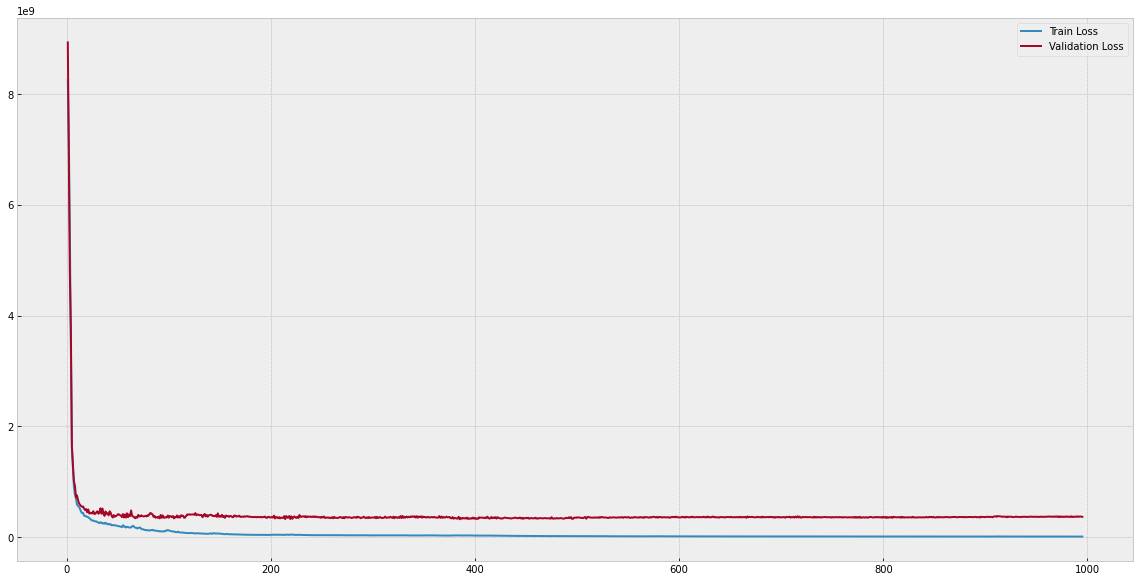

In [48]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][5:]
_val_loss = history.history['val_loss'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

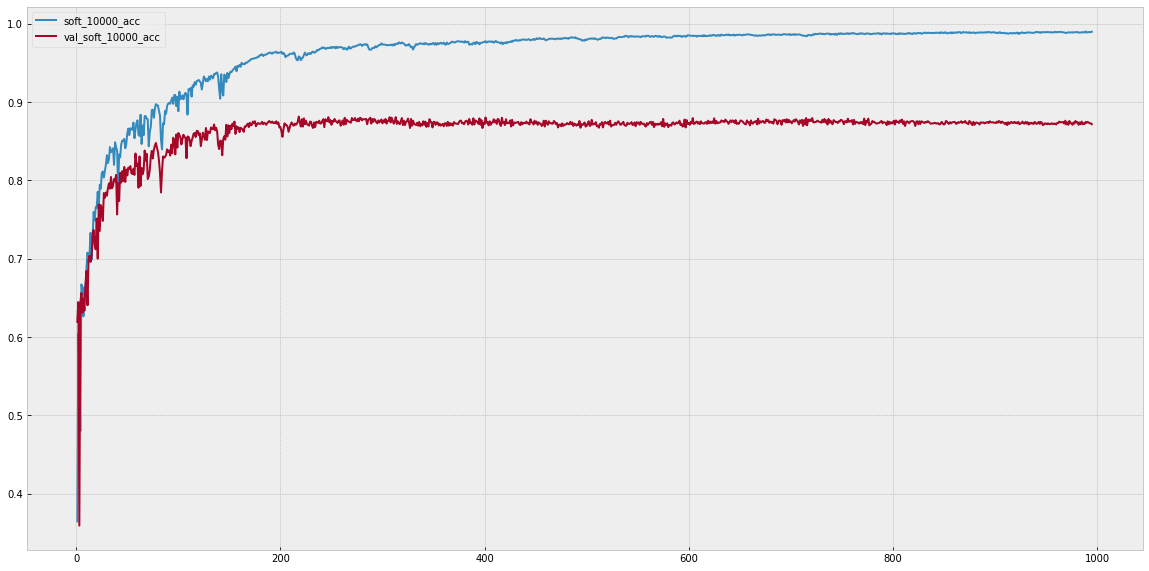

In [49]:
plt.figure(figsize=(20,10))
_loss = history.history['soft_10000_acc'][5:]
_val_loss = history.history['val_soft_10000_acc'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='soft_10000_acc')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='val_soft_10000_acc')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: -6531
The mean is very close to 0 (493.68) with std. 19111.44.


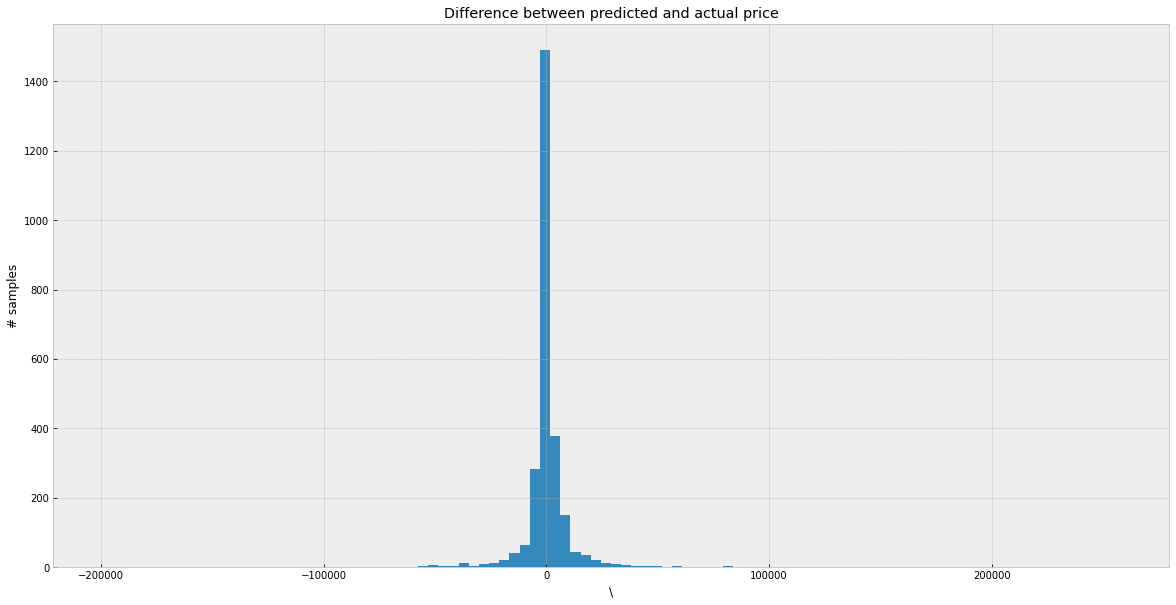

,NAFYC,pred,abs_diff,abs_%diff,DIV
5366,-268913.897000,-12068.399414,256845.497586,95.512170,철회
46187,-233498.057143,-27076.976562,206421.080580,88.403768,실효
1622,-36175.316211,-234917.640625,198742.324414,549.386558,해약
64892,-52223.493976,-243911.156250,191687.662274,367.052542,실효
5814,-63014.509714,-243285.796875,180271.287161,286.079013,해약
59396,-261271.296000,-81095.476562,180175.819438,68.961199,해약
62968,-26042.376247,-199801.515625,173759.139378,667.216915,해약
84366,-730465.050000,-560971.875000,169493.175000,23.203461,변경
92429,-189986.188533,-21669.630859,168316.557674,88.594102,변경
4860,-189143.576471,-26185.699219,162957.877252,86.155650,철회


In [51]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['code_mapping'],X_val_categorical['div_mapping'],X_val_categorical['eventint_mapping'],X_val_categorical['comrate_mapping'],X_val_categorical['minusrate_mapping']])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset2)[['NAFYC','pred','abs_diff','abs_%diff','DIV']]
b.head(10)